In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#%tensorflow_version 2.3
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [3]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import warnings
warnings.filterwarnings("ignore")
!pip install -U git+https://github.com/qubvel/efficientnet
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install --upgrade opencv-python
!pip install --upgrade opencv-contrib-python
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-sdio8c_p
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-sdio8c_p
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18421 sha256=c5ce3dca33e0897cb66a46a029b80574a22535fe5ec566f46cc9888e0f59ab9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-i9sbqxx_/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
Requirement already up-to-date: opencv-python in /usr/local/lib/python3.7/dist-packages (4.5.2.52)
Requirement already up-to-date: opencv-contrib-python in /usr/local/lib/python3.7/dist-packages (4.5.2.52)


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import time
from cv2 import dnn_superres
import os
import cv2
import re
from os import path
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, Dropout

import matplotlib.pyplot as plt
import pickle
import math
from sklearn.metrics import confusion_matrix

from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import keras
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras import layers
from keras import regularizers
import efficientnet.tfkeras
import datetime, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.OUTPUT_DIR = '/content/drive/MyDrive/GG1'

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [7]:
class Model:
    def __init__(self, model, base_path='/content/drive/MyDrive/Super resolution_Going_from_3x_to_8x_Resolution/models/'):
    
      # Create an SR object
      self.sr = dnn_superres.DnnSuperResImpl_create()
      
      # Define model path
      self.model_path = os.path.join(base_path , model +".pb")
      
      # Extract model name from model path
      self.model_name = model.split('_')[0].lower()
      
      # Extract model scale from model path
      self.model_scale = int(model.split("_")[1][1])
          
      # Read the desired model
      self.sr.readModel(self.model_path)
      
      self.sr.setModel(self.model_name, self.model_scale)

    def super_res(self, image):
      
      #%%time
      # Upscale the image
      self.Final_Img = self.sr.upsample(image)
      #print(self.model_name, self.model_scale)

      #print('Shape of Original Image: {} , Shape of Super Resolution Image: {}'.format(image.shape, self.Final_Img.shape))
          
      return self.Final_Img


LA = Model("LapSRN_x8")

In [8]:
from keras.backend import sigmoid
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

def swish_activation(x):
        return (K.sigmoid(x) * x)

get_custom_objects().update({'SwishActivation': Activation(swish_activation)})

get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [9]:
import efficientnet.keras
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/models/efficientnetb6/eff.h5")

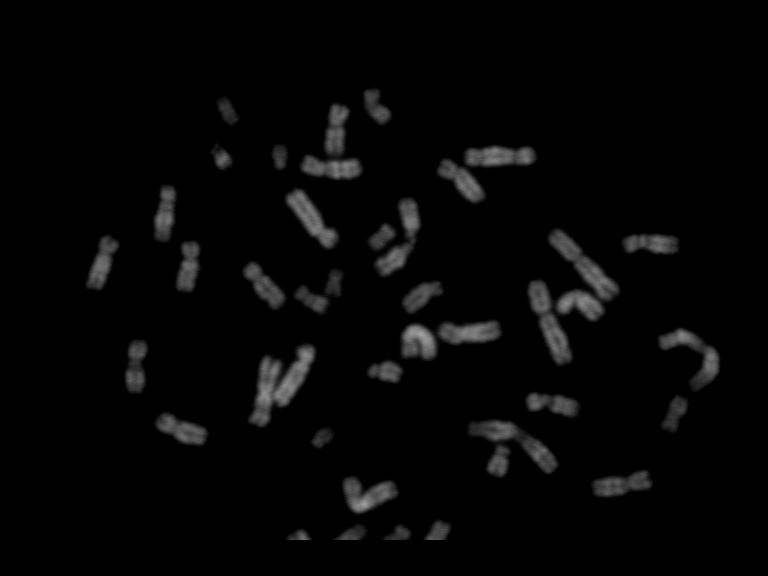

In [21]:
# We can use `Visualizer` to draw the predictions on the image.
im = cv2.imread("/content/drive/MyDrive/Chromosome_JPG/original 113c.png")
cv2_imshow(im)


In [22]:
outputs = predictor(im)
bbout = outputs["instances"].to("cpu")
bbout = list(bbout.pred_boxes)
nums = {}
imgs = {}
for i in tqdm(range(len(bbout))):
  c1,c2,d1,d2 = np.array(bbout[i], dtype =int)

  thickness = 2
  img = im[c2:d2, c1:d1]
  img = LA.super_res(img)
  img = cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)
  imge = np.expand_dims(img, 0)

  num = np.argmax(model.predict(imge))
  if num in nums:
    nums[num] += 1
    imgs[num].append(img)
  else:
    nums[num] = 1
    imgs[num] = [img]
  

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


In [23]:
for a in nums:
  print("Number of Chromosomes of no.",a, "is",nums[a])

Number of Chromosomes of no. 18 is 2
Number of Chromosomes of no. 8 is 8
Number of Chromosomes of no. 14 is 6
Number of Chromosomes of no. 4 is 3
Number of Chromosomes of no. 20 is 4
Number of Chromosomes of no. 6 is 6
Number of Chromosomes of no. 15 is 1
Number of Chromosomes of no. 7 is 2
Number of Chromosomes of no. 12 is 4
Number of Chromosomes of no. 17 is 2
Number of Chromosomes of no. 13 is 2
Number of Chromosomes of no. 3 is 1


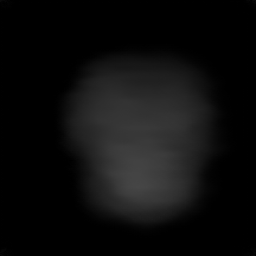

In [25]:
a = 3
for image in imgs[a]:
  cv2_imshow(image)